# Volume Response Model Single Market Maker - via Pontryagin

This notebook corresponds to section 4 (**Agent based models**) of "Market Based Mechanisms for Incentivising Exchange Liquidity Provision" available [here](https://vega.xyz/papers/liquidity.pdf). It models a single market maker and solves the resulting game by an iterative scheme based on the Pontryagin optimality principle.

## Problem formulation

$$ dX_t = b\left(\mathbf{X},\mathbf{\theta}\right)dt$$
where

$$\mathbf{X}_t = \left[ V_t, f_t, S_t \right], \quad  \mathbf{\theta}_t = \left[ \alpha^f_t, \alpha^S_t \right] $$

and
$$ dV_t = \kappa_D \left( \text{LD}_F^{\ast} - \frac{V_t}{\kappa_S S_t} \right)V_t dt - \kappa_f\frac{1}{1 + \exp(-(f_t-\text{FP}^{\text{mid}}))}V_t dt, \quad V_0 = v_0$$ 

where:

* $V_t \text{ denotes trading volume at time } t,$
* $S_t \text{ denotes stake level at time } t,$
* $f_t \text{ denotes fee level at time } t,$
* $LD_F^{\ast} \text{ denotes liquidity demand mean-reversion level and corresponds to parameter } \verb|liq_dem_F_star| \text{ in the code}$,
* $\text{FP}^{\text{mid}} = \verb|fee_param_mid| $




$$ $$

$$b\left(\mathbf{X},\mathbf{\theta}\right) = \begin{bmatrix}
\kappa_D \left( \text{LD}_F^{\ast} - \frac{V}{\kappa_S S} \right)V - \kappa_f\frac{1}{1 + \exp(-(f_t-\text{FP}^{\text{mid}}))}V \\
\alpha^f \\
\alpha^S \\
\end{bmatrix}$$

Maximise: 
$$ J\left(\alpha^f, \alpha^S \right) = \int_0^T F\left(\mathbf{X}_t, \mathbf{\theta}_t \right) dt$$
where
$$F\left(\mathbf{X}_t, \mathbf{\theta}_t \right) := \frac{1}{1 + \exp(-(f_t-\text{FP}^{\text{mid}}))} V_t - \gamma S_t-\frac{\delta_f}{2}(\alpha_t^f)^2-\frac{\delta_S}{2}(\alpha_t^S)^2$$

Let:

$$H(\mathbf{X}_t, \mathbf{\theta}_t, p) = b\left(\mathbf{X}_t,\mathbf{\theta}_t\right) \cdot p + F\left(\mathbf{X}_t, \mathbf{\theta}_t \right)$$

In [1]:
import math, sys 
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path
count = 0

from matplotlib.backends.backend_pdf import PdfPages

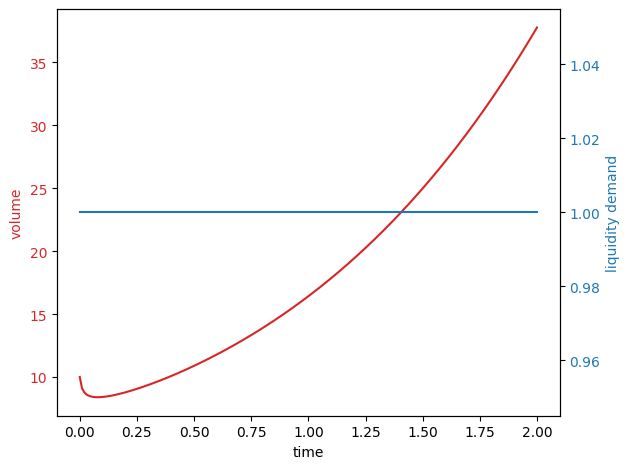

Gain is 8.393902
[ 0.5         0.          2.50000001 -0.05      ]
[0.99999994 0.99999994]


In [2]:
# Parameter for approximating partial derivatives
fd_delta = 1e-7

# Fix time discretization
T = 2.0
N_T = 200
delta_t = T / (N_T-1)

kappa_D = 1.0

kappa_f = 1.0
kappa_S = 1.0

gamma = 0.05; # cost of capital
delta_f = 1e-6 # penalty for fee change
delta_S = 1e-16 # penalty for stake change


initial_volume = 10
initial_stake = 1.0
fee_param_mid = 5.0
initial_fee = 5.0
liq_dem_F_star = 1.5


# 0 is volume
# 1 is log of liquidity demand
# 2 is fee
# 3 is stake
x_vals = np.zeros([4,N_T+1])
x_vals[0,0] = initial_volume
x_vals[1,0] = 0
x_vals[2,0] = initial_fee
x_vals[3,0] = initial_stake

# thetas[0,:] controls fees, thetas[1,:] controls the stake
thetas = np.zeros([2,N_T+1])

def fee_param_logistic(f):
    return 1.0/(1.0+np.exp(-(f-fee_param_mid)))


def drift_forward(x, theta):
    V = x[0]; f = x[2]; S = x[3]; alpha_f = theta[0]; alpha_S = theta[1]
    fee = fee_param_logistic(f)
    #fee = 0.01
    
    b = np.zeros(4)
    
    b[0] = kappa_D * (liq_dem_F_star - V / (kappa_S * S)) * V -  kappa_f * fee * V 
    b[1] = 0 
    b[2] = alpha_f  
    b[3] = alpha_S    
    return b


def running_gain(x, theta):
    f = x[2]; V = x[0]; stake = x[3]; alpha_f = theta[0]; alpha_s = theta[1]
    fee = fee_param_logistic(f)
    gain = fee * V - gamma*stake - 0.5*delta_f*alpha_f**2 - 0.5*delta_S*alpha_s**2
    return gain 

def hamiltonian(x,p,theta):
    return np.dot(drift_forward(x,theta),p) + running_gain(x,theta)

def grad_in_x_of_hamiltonian(x,p,theta):
    dim = np.size(x)
    grad = np.zeros(dim)
    for i in range(0,dim):
        x_plus_delta = np.copy(x); x_plus_delta[i] = x[i] + fd_delta
        H_plus = hamiltonian(x_plus_delta,p,theta)
        #print(H_plus)
        #H_minus = hamiltonian(x_minus_delta,p,theta)
        H = hamiltonian(x,p,theta)
        #print(H_minus)
        grad[i] = (H_plus - H)/fd_delta
    return grad

def grad_in_theta_of_hamiltonian(x,p,theta):
    dim = np.size(theta)
    grad = np.zeros(dim)
    for i in range(0,dim):
        theta_plus_delta = np.copy(theta); theta_plus_delta[i] = theta[i] + fd_delta
        theta_minus_delta = np.copy(theta); theta_minus_delta[i] = theta[i] - fd_delta
        H_plus = hamiltonian(x,p,theta_plus_delta)
        H_minus = hamiltonian(x,p,theta_minus_delta)
        grad[i] = (H_plus - H_minus)/(2*fd_delta)
    
    return grad

def calc_gain(x_vals, thetas):
    gain = 0 
    for i in range(0,N_T):
        gain = gain + running_gain(x_vals[:,i], thetas[:,i])*delta_t
    return gain

for i in range(0,N_T):
        thetas[0,i] = 0.0
        thetas[1,i] = 100.0
        
        x_vals[:,i+1] = x_vals[:,i] + drift_forward(x_vals[:,i],thetas[:,i]) * delta_t

t_span = np.linspace(0, T, N_T+1)
color = 'tab:red'
fig, ax1 = plt.subplots()
ax1.set_xlabel('time')
ax1.set_ylabel('volume', color=color)
ax1.plot(t_span, x_vals[0,:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('liquidity demand', color=color)  # we already handled the x-label with ax1
ax2.plot(t_span, np.exp(x_vals[1,:]), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Gain is %f' % (calc_gain(x_vals, thetas)))
print(grad_in_x_of_hamiltonian(x_vals[:,0], np.zeros(4), thetas[:,0]))
print(grad_in_theta_of_hamiltonian(x_vals[:,0], np.ones(4), thetas[:,0]))

In [3]:
# Fix learning rate rho
rho = 10
max_iter = 2000
max_error = 0.000001

# Fix time discretization
delta_t = T / (N_T-1)

# alpha_f is the 0th row, alpha_s the 1st row
thetas = np.zeros([2,N_T+1])
thetas_old = np.zeros([2,N_T+1])

x_vals = np.zeros([4,N_T+1])
x_vals[0,0] = initial_volume
x_vals[1,0] = 0
x_vals[2,0] = initial_fee
x_vals[3,0] = initial_stake


for i in range(0,N_T):
    thetas_old[0,i] = 0.0
    thetas_old[1,i] = 100


p_vals = np.zeros([4,N_T+1])

diff = 0; failed_to_converge=True

gain_old = 0
for iter_idx in range(0,max_iter):
    # Run x forwards
    for i in range(0,N_T):
        x_vals[:,i+1] = x_vals[:,i]  + drift_forward(x_vals[:,i],thetas_old[:,i]) * delta_t
    
    # Run p backwards
    p_vals[:,N_T] = np.zeros(4)
    for i in reversed(range(0,N_T)):
        grad_x_of_Ham = grad_in_x_of_hamiltonian(x_vals[:,i+1],p_vals[:,i+1],thetas[:,i+1])
        p_vals[:,i] = p_vals[:,i+1] + grad_x_of_Ham * delta_t 
    
    for i in range(0,N_T+1):
        # Do one gradient ascent step (we are maximizing) 
        thetas[:,i] = thetas_old[:,i] + rho*grad_in_theta_of_hamiltonian(x_vals[:,i], p_vals[:,i], thetas_old[:,i])
        
    gain = calc_gain(x_vals, thetas)    
    diff =  gain - gain_old
    
    if (math.isnan(gain)):
        print('FAILED; iteration %d, diff is nan.' % iter_idx)
        break
    
    if (abs(diff) < max_error):
        print('Converged; iteration %d, diff is %f' % (iter_idx, diff))
        failed_to_converge = False
        break 
        
    thetas_old = np.copy(thetas); gain_old = gain
    if iter_idx % 50 == 0:
        print('Iter %d, Gain is %f' % (iter_idx, gain))
        
if failed_to_converge:
    print('Failed after %d iteration, diff is %f' % (max_iter, diff))
    
   
print('Gain is %f' % (calc_gain(x_vals, thetas)))

Iter 0, Gain is 8.392212
Iter 50, Gain is 15.330476
Iter 100, Gain is 22.955457
Iter 150, Gain is 23.907274
Iter 200, Gain is 24.353099
Iter 250, Gain is 24.658995
Iter 300, Gain is 24.895052
Iter 350, Gain is 25.088258
Iter 400, Gain is 25.251340
Iter 450, Gain is 25.391379
Iter 500, Gain is 25.512885
Iter 550, Gain is 25.619045
Iter 600, Gain is 25.712272
Iter 650, Gain is 25.794483
Iter 700, Gain is 25.867246
Iter 750, Gain is 25.931863
Iter 800, Gain is 25.989432
Iter 850, Gain is 26.040882
Iter 900, Gain is 26.087007
Iter 950, Gain is 26.128487
Iter 1000, Gain is 26.165906
Iter 1050, Gain is 26.199766
Iter 1100, Gain is 26.230501
Iter 1150, Gain is 26.258486
Iter 1200, Gain is 26.284047
Iter 1250, Gain is 26.307465
Iter 1300, Gain is 26.328986
Iter 1350, Gain is 26.348824
Iter 1400, Gain is 26.367163
Iter 1450, Gain is 26.384167
Iter 1500, Gain is 26.399977
Iter 1550, Gain is 26.414719
Iter 1600, Gain is 26.428501
Iter 1650, Gain is 26.441418
Iter 1700, Gain is 26.453556
Iter 1750

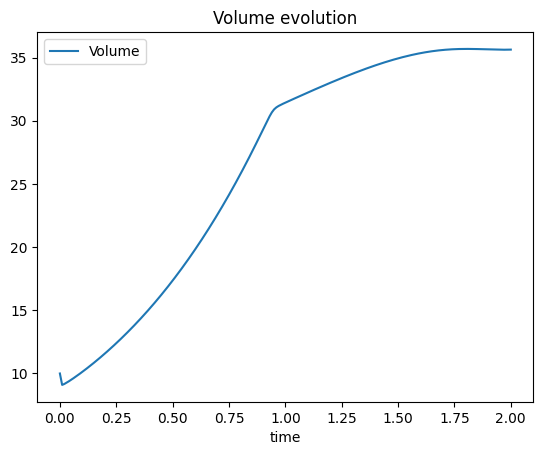

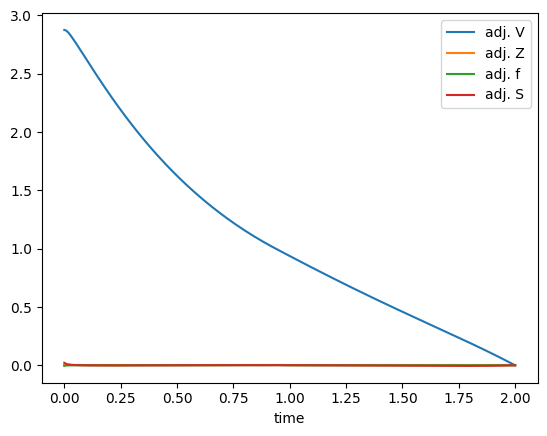

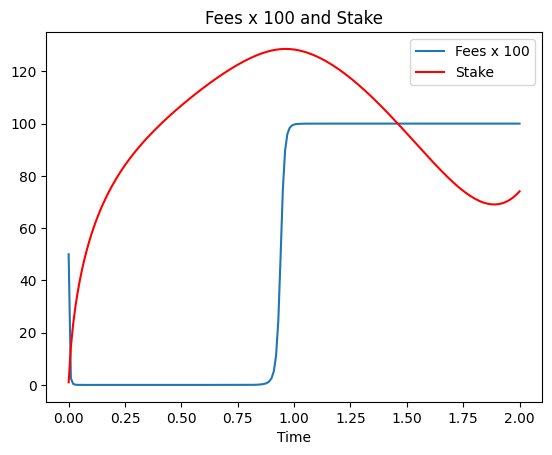

In [4]:
t_span = np.linspace(0, T, N_T+1)
plt.plot(t_span, x_vals[0,:], label='Volume')
plt.title('Volume evolution')
plt.xlabel('time')
plt.legend()

fig = plt.figure()
plt.plot(t_span, p_vals[0,:], label='adj. V')
plt.plot(t_span, p_vals[1,:], label='adj. Z')
plt.plot(t_span, p_vals[2,:], label='adj. f')
plt.plot(t_span, p_vals[3,:], label='adj. S')
plt.xlabel('time')
plt.legend()

fig = plt.figure()
plt.plot(t_span, 100*fee_param_logistic(x_vals[2,:]), label='Fees x 100')
plt.title('Fees')
plt.xlabel('time')

plt.plot(t_span, x_vals[3,:], color='red',label='Stake')
plt.title('Fees x 100 and Stake')
plt.xlabel('Time')
plt.legend()



In [5]:
np.exp(10*0.01)

1.1051709180756477

In [6]:
def grad_in_V_of_Hamiltonian(V,Z,f,S,p_V,p_Z):
    return ( kappa_V - kappa_D*np.exp(Z) - kappa_f*f )*p_V + (1.0/V) * p_Z + f

def grad_in_Z_of_Hamiltonian(V,Z,f,S,p_V,p_Z):
    return (-kappa_D * np.exp(Z)*V)*p_V

def grad_in_f_of_Hamiltonian(V,Z,f,S,p_V,p_Z):
    return - kappa_f*V*p_V + V

def grad_in_S_of_Hamiltonian(V,Z,f,S,p_V,p_Z):
    return -(1.0/S)*p_Z - gamma

def grad_in_x_of_hamiltonian_exact(x,p,theta):
    V = x[0]; Z = x[1]; f = x[2]; S = x[3]; p_V = p[0]; p_Z = p[1]
    grad_in_x_of_H = np.zeros(4)
    grad_in_x_of_H[0] = grad_in_V_of_Hamiltonian(V,Z,f,S,p_V,p_Z)
    grad_in_x_of_H[1] = grad_in_Z_of_Hamiltonian(V,Z,f,S,p_V,p_Z)
    grad_in_x_of_H[2] = grad_in_f_of_Hamiltonian(V,Z,f,S,p_V,p_Z)
    grad_in_x_of_H[3] = grad_in_S_of_Hamiltonian(V,Z,f,S,p_V,p_Z)
    return grad_in_x_of_H

def grad_in_alpha_f_of_Hamiltonian(p_f,alpha_f):
    return p_f - delta_f * alpha_f

def grad_in_alpha_S_of_Hamiltonian(p_S, alpha_S):
    return p_S - delta_S * alpha_S

def grad_in_theta_of_hamiltonian_exact(x,p,theta):
    p_f = p[2]; p_S = p[3]; alpha_f = theta[0]; alpha_S = theta[1]
    grad_in_theta_of_H = np.zeros(2)
    grad_in_theta_of_H[0] = grad_in_alpha_f_of_Hamiltonian(p_f,alpha_f)
    grad_in_theta_of_H[1] = grad_in_alpha_S_of_Hamiltonian(p_S,alpha_S)
    return grad_in_theta_of_H
